<a href="https://colab.research.google.com/github/vonvolous/d2l/blob/main/code/D2l_10_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

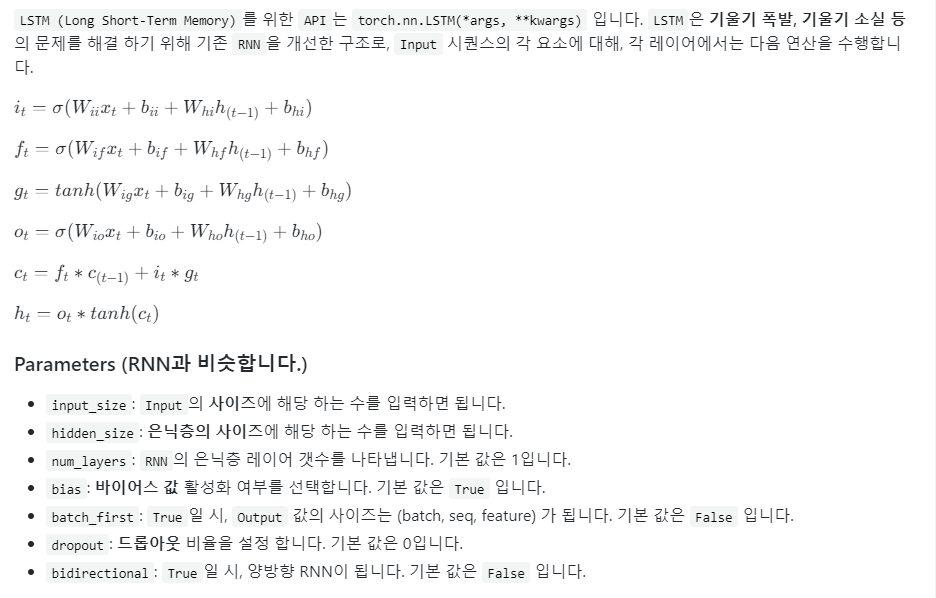

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [7]:
sentences = ["i like dog", "i love coffee", "i hate milk", "you like cat", "you love milk", "you hate coffee"]
dtype = torch.float

Word Processing

In [8]:
word_list = list(set(" ".join(sentences).split())) # sentences안에서 중복되지 않는 단어 목록 생성
word_dict = {w: i for i, w in enumerate(word_list)}
num_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)

word_dict

{'coffee': 0,
 'love': 1,
 'hate': 2,
 'like': 3,
 'you': 4,
 'i': 5,
 'dog': 6,
 'milk': 7,
 'cat': 8}

TextRNN Parameter

In [9]:
batch_size = len(sentences)
n_step = 2 # 학습 하려는 문장의 길이 - 1
n_hidden = 5 # 은닉층 사이즈

In [5]:
def make_batch(sentences):
    input_batch = []
    target_batch = []

    for sen in sentences:
        word = sen.split()
        input = [word_dict[n] for n in word[:-1]]
        target = word_dict[word[-1]]

        input_batch.append(np.eye(n_class)[input])
        target_batch.append(target)
    return input_batch, target_batch

In [10]:
input_batch, target_batch = make_batch(sentences)

In [11]:
input_batch

[array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.]])]

In [12]:
target_batch

[6, 0, 7, 8, 7, 0]

In [13]:
input_batch = torch.tensor(input_batch, dtype=torch.float32, requires_grad=True)
target_batch = torch.tensor(target_batch, dtype=torch.int64)

TextLSTM

In [18]:
class TextLSTM(nn.Module):
    def __init__(self):
        super(TextLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
        self.w = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
        self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
        self.Softmax = nn.Softmax(dim=1)

    def forward(self, hidden_and_cell, x):
        x = x.transpose(0, 1)
        outputs, hidden = self.lstm(x, hidden_and_cell)
        outputs = outputs[-1] # 최종 예측 hidden layer
        model = torch.mm(outputs, self.w) + self.b
        return model

Training

In [20]:
model = TextLSTM()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(5):
    hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
    cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
    output = model((hidden, cell), input_batch)
    loss = criterion(output, target_batch)

    print('Epoch: ', '%04d' % (epoch+1), 'cost =', '{:.6f}'.format(loss))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

input = [sen.split()[:2] for sen in sentences]

hidden = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
cell = torch.zeros(1, batch_size, n_hidden, requires_grad=True)
predict = model((hidden, cell), input_batch).data.max(1, keepdim=True)[1]
print([sen.split()[:2] for sen in sentences], '->', [num_dict[n.item()] for n in predict.squeeze()])

Epoch:  0001 cost = 1.998108
Epoch:  0002 cost = 1.963673
Epoch:  0003 cost = 1.929434
Epoch:  0004 cost = 1.895454
Epoch:  0005 cost = 1.861748
[['i', 'like'], ['i', 'love'], ['i', 'hate'], ['you', 'like'], ['you', 'love'], ['you', 'hate']] -> ['coffee', 'coffee', 'coffee', 'coffee', 'coffee', 'coffee']
